<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/computer_vision/eulerian_magnification/eulerian_magnification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Eulerian Video Magnification
##Import modules

In [2]:
import os
import cv2
import numpy as np
import scipy.fftpack
import scipy.signal
from matplotlib import pyplot
import requests

##Helper functions

In [3]:
def uint8_to_float(data):
    result = np.ndarray(shape=data.shape, dtype='float')
    result[:] = data * (1. / 255)
    return result

def float_to_uint8(data):
    result = np.ndarray(shape=data.shape, dtype='uint8')
    result[:] = data * 255
    return result

def load_video(video_filename):
    video_filename = str(video_filename)
    print("Loading " + video_filename)
    if not os.path.isfile(video_filename):
        raise Exception("File Not Found: %s" % video_filename)
    capture = cv2.VideoCapture(video_filename)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    width, height = get_capture_dimensions(capture)
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    x = 0
    vid_frames = np.zeros((frame_count, height, width, 3), dtype='uint8')
    while capture.isOpened():
        ret, frame = capture.read()
        if not ret:
            break

        vid_frames[x] = frame
        x += 1
    capture.release()

    return vid_frames, fps

def load_video_float(video_filename):
    vid_data, fps = load_video(video_filename)
    return uint8_to_float(vid_data), fps

def get_capture_dimensions(capture):
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return width, height

def save_video(video, fps, save_filename='output.mp4'):
    video = float_to_uint8(video)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    writer = cv2.VideoWriter(save_filename, fourcc, fps, (video.shape[2], video.shape[1]), 1)
    for x in range(0, video.shape[0]):
        res = cv2.convertScaleAbs(video[x])
        writer.write(res)
    print('output saved to ' + save_filename)

##Spatial decomposition, temporal filtering and reconstruction

In [4]:
def create_gaussian_image_pyramid(image, pyramid_levels):
    """ Creates a gaussian image pyramid for the input image"""
    gauss_copy = np.ndarray(shape=image.shape, dtype="float")
    gauss_copy[:] = image
    img_pyramid = [gauss_copy]
    for pyramid_level in range(1, pyramid_levels):
        gauss_copy = cv2.pyrDown(gauss_copy)
        img_pyramid.append(gauss_copy)

    return img_pyramid

def create_laplacian_image_pyramid(image, pyramid_levels):
    """ Creates a laplacian image pyramid for the input image"""
    gauss_pyramid = create_gaussian_image_pyramid(image, pyramid_levels)
    laplacian_pyramid = []
    for i in range(pyramid_levels - 1):
        laplacian_pyramid.append((gauss_pyramid[i] - cv2.pyrUp(gauss_pyramid[i + 1])))

    laplacian_pyramid.append(gauss_pyramid[-1])
    return laplacian_pyramid

def create_laplacian_video_pyramid(video, pyramid_levels):
    """Creates a laplacian video pyramid for the input video"""
    vid_pyramid = []
    for frame_number, frame in enumerate(video):
        frame_pyramid = create_laplacian_image_pyramid(frame, pyramid_levels)

        for pyramid_level, pyramid_sub_frame in enumerate(frame_pyramid):
            if frame_number == 0:
                vid_pyramid.append(
                    np.zeros((video.shape[0], pyramid_sub_frame.shape[0], pyramid_sub_frame.shape[1], 3),
                                dtype="float"))

            vid_pyramid[pyramid_level][frame_number] = pyramid_sub_frame

    return vid_pyramid

def temporal_bandpass_filter(data, fps, freq_min=0.833, freq_max=1, axis=0, amplification_factor=1):
    """
     filters out the motion information and returns
     an amplified version of the motion information.
    """
    fft = scipy.fftpack.rfft(data, axis=axis)
    frequencies = scipy.fftpack.fftfreq(data.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - freq_min)).argmin()
    bound_high = (np.abs(frequencies - freq_max)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0

    result = np.ndarray(shape=data.shape, dtype='float')
    result[:] = np.abs(scipy.fftpack.ifft(fft, axis=0))
    result *= amplification_factor
    return result

def collapse_laplacian_pyramid(image_pyramid):
    """returns the reconstructed image from the input laplacian pyramid"""
    img = image_pyramid.pop()
    while image_pyramid:
        img = cv2.pyrUp(img) + (image_pyramid.pop() - 0)

    return img

def collapse_laplacian_video_pyramid(pyramid):
    """returns the reconstructed video from the input laplacian video pyramid"""
    i = 0
    while True:
        try:
            img_pyramid = [vid[i] for vid in pyramid]
            pyramid[0][i] = collapse_laplacian_pyramid(img_pyramid)
            i += 1
        except IndexError:
            break
    return pyramid[0]

##Motion magnification

In [5]:
def eulerian_magnification(vid_data, fps, freq_min, freq_max, amplification, pyramid_levels=4, skip_levels_at_top=1):
    """ Returns the motion magnified video"""
    print("creating video pyramid....")
    vid_pyramid = create_laplacian_video_pyramid(vid_data, pyramid_levels=pyramid_levels)
    for i, vid in enumerate(vid_pyramid):
        if i < skip_levels_at_top or i >= len(vid_pyramid) - 1:
            # ignore the top and bottom of the pyramid. One end has too much noise and the other end is the
            # gaussian representation
            continue

        bandpassed = temporal_bandpass_filter(vid, fps, freq_min=freq_min, freq_max=freq_max, amplification_factor=amplification)

        vid_pyramid[i] += bandpassed

    print("bandpass filtering "+str([freq_min,freq_max])+"Hz...")
    vid_data = collapse_laplacian_video_pyramid(vid_pyramid)
    print("reconstructing from pyramid...")
    print("Done")
    return vid_data

##Show frequencies

In [6]:
def show_frequencies(vid_data, fps, bounds=None):
    """Graph the average value of the video as well as the frequency strength"""
    averages = []
    if bounds:
        for x in range(1, vid_data.shape[0] - 1):
            averages.append(vid_data[x, bounds[2]:bounds[3], bounds[0]:bounds[1], :].sum())
    else:
        for x in range(1, vid_data.shape[0] - 1):
            averages.append(vid_data[x, :, :, :].sum())

    averages = averages - min(averages)

    charts_x = 1
    charts_y = 2
    pyplot.figure(figsize=(20, 10))
    pyplot.subplots_adjust(hspace=.7)
    pyplot.subplot(charts_y, charts_x, 1)
    pyplot.title("Pixel Average")
    pyplot.xlabel("Time")
    pyplot.ylabel("Brightness")
    pyplot.plot(averages)

    freqs = scipy.fftpack.fftfreq(len(averages), d=1.0 / fps)
    fft = abs(scipy.fftpack.fft(averages))
    idx = np.argsort(freqs)

    pyplot.subplot(charts_y, charts_x, 2)
    pyplot.title("FFT")
    pyplot.xlabel("Freq (Hz)")
    freqs = freqs[idx]
    fft = fft[idx]

    freqs = freqs[len(freqs) // 2 + 1:]
    fft = fft[len(fft) // 2 + 1:]
    pyplot.plot(freqs, abs(fft))
    pyplot.show()

##Download

In [7]:
filename = 'video.mp4'

In [8]:
def download_file(url, dest_filename):
    if os.path.isfile(dest_filename):
        print('Already Downloaded: %s to %s' % (url, dest_filename))
        return
    print('Downloading: %s to %s' % (url, dest_filename))

    response = requests.get(url, stream=True)
    if not response.ok:
        raise Exception("Couldn't download file")

    with open(dest_filename, 'wb') as fp:
        for block in response.iter_content(1024):
            fp.write(block)

download_file('http://people.csail.mit.edu/mrub/evm/video/face.mp4',filename)

Downloading: http://people.csail.mit.edu/mrub/evm/video/face.mp4 to video.mp4


##Final demo

Loading video.mp4


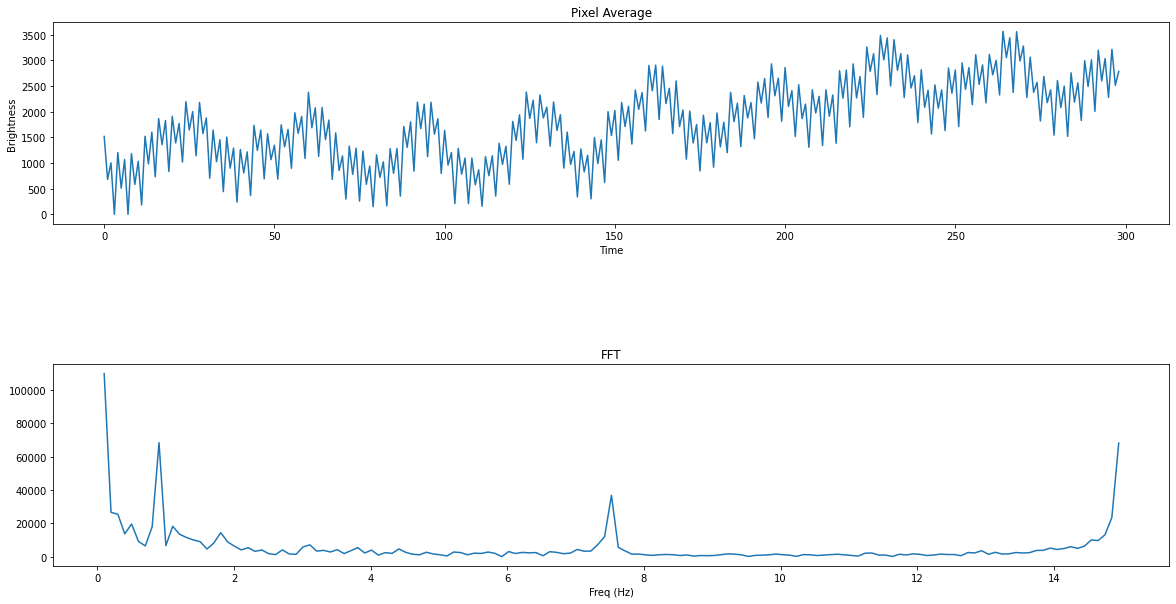

In [9]:
vid, fps = load_video_float(filename)
show_frequencies(vid, fps)

In [10]:
lower_hertz = 0.5
upper_hertz = 2
amplification_factor = 15
pyramid_levels = 4

mag_vid = eulerian_magnification(
    vid, fps,
    freq_min=lower_hertz,
    freq_max=upper_hertz,
    amplification=amplification_factor,
    pyramid_levels=pyramid_levels
)

creating video pyramid....
bandpass filtering [0.5, 2]Hz...
reconstructing from pyramid...
Done


In [11]:
out_name = filename.split(".")[0] + "_levels_" + str(pyramid_levels) + "_min_" + str(
    lower_hertz) + "_max_" + str(upper_hertz) + "_amp_" + str(amplification_factor)+'.mp4'
    
save_video(mag_vid, fps, out_name)

output saved to video_levels_4_min_0.5_max_2_amp_15.mp4
